<a href="https://colab.research.google.com/github/alliwene/fuel-efficiency/blob/main/fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> <b>  FUEL EFFICIENCY PREDICTION </b> </center> 

Create a model to predict fuel efficiency of vehicles in the late 1970s and early 1980s. 

### Import libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter(action='ignore')

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (15, 5)
sns.set(context="paper", font="monospace")

### Load and clean data

In [3]:
data = pd.read_csv('auto-mpg.csv', na_values="?")
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [4]:
data.shape

(398, 9)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


Drop 'car name' column

In [6]:
data.drop('car name', axis=1, inplace=True)

In [7]:
data.shape

(398, 8)

In [8]:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

horsepower column has null values. Fill null values with median

In [9]:
data['horsepower'].fillna(data['horsepower'].median(), inplace=True)
sum(data.isna().sum().values)

0

Check number of unique elements in each column

In [10]:
for col in data.columns:
    unique = data[col].unique()
    print('Column {} has {} unique values'.format(col, len(unique)))

Column mpg has 129 unique values
Column cylinders has 5 unique values
Column displacement has 82 unique values
Column horsepower has 94 unique values
Column weight has 351 unique values
Column acceleration has 95 unique values
Column model year has 13 unique values
Column origin has 3 unique values


In [11]:
data['cylinders'].unique()

array([8, 4, 6, 3, 5])

In [12]:
data['origin'].unique()

array([1, 3, 2])

### Quick EDA

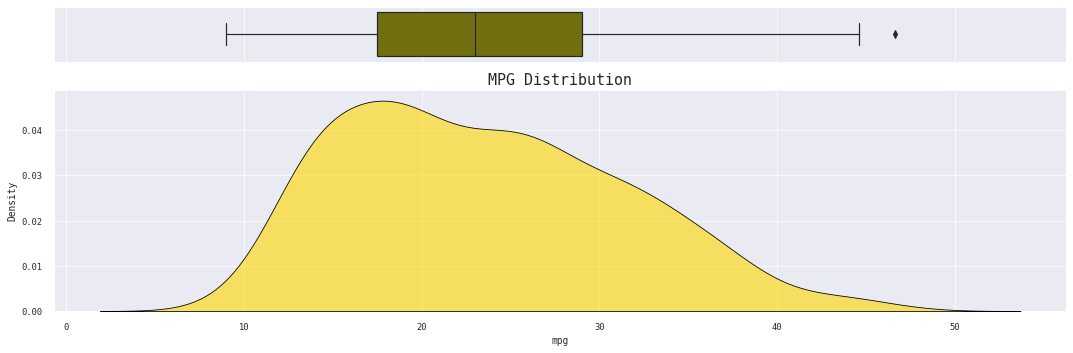

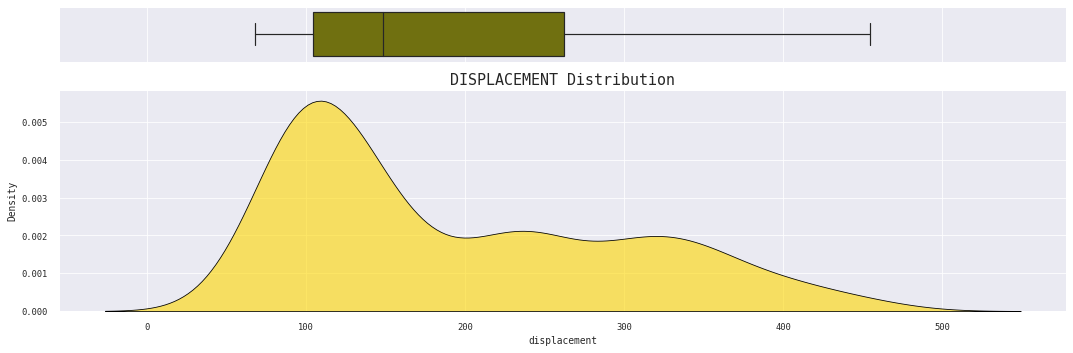

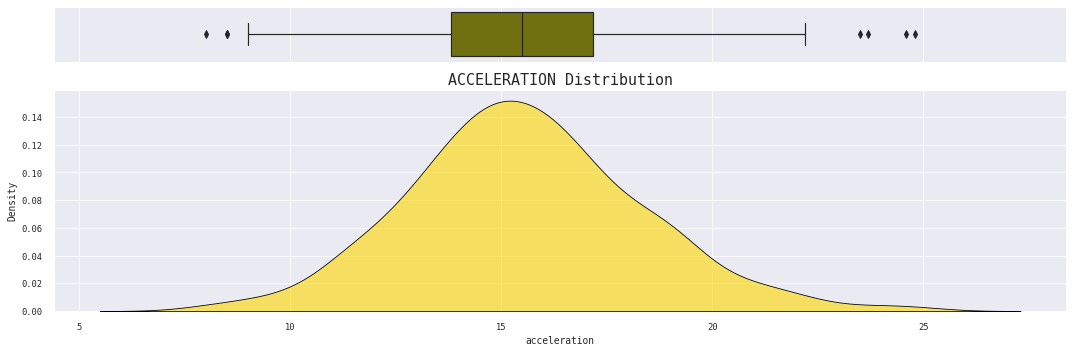

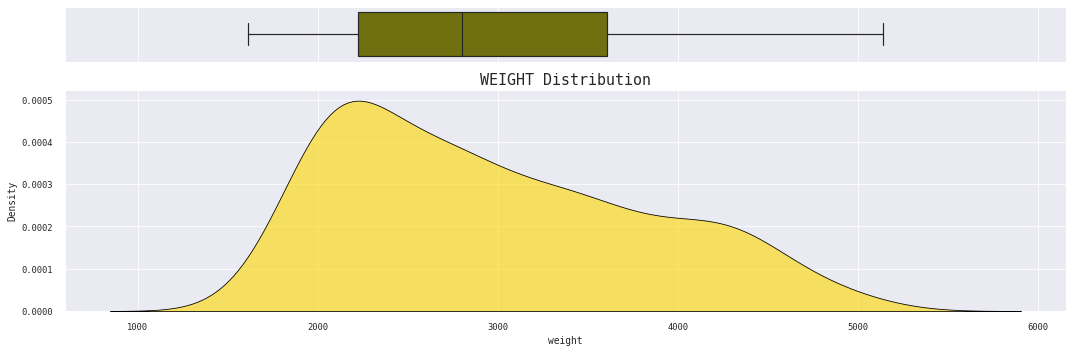

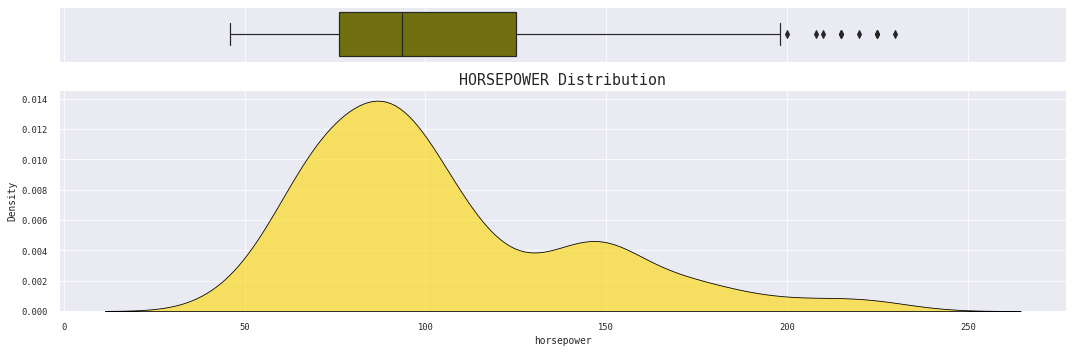

In [13]:
float_cols = ['mpg', 'displacement', 'acceleration', 'weight', 'horsepower']
for col in float_cols:
    ax = [None for i in range(2)]
    # set 2 subplots and set ratio of plots 
    f, (ax[0], ax[1]) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.20, .80)
                                        })   
    g1 = sns.boxplot(col, ax=ax[0], data=data, color='olive') # boxplot
    g1.set(xlabel=None) # remove x axis label for boxplot
    g2 = sns.kdeplot(data[col], ax=ax[1], shade=True, color='gold', alpha=0.6, 
                     zorder=3, edgecolor='black') # distribution plot
    plt.title(col.upper()+' Distribution', size=15)
    plt.tight_layout()
    plt.show()

In [14]:
# sns.pairplot(data[float_cols], diag_kind="kde");

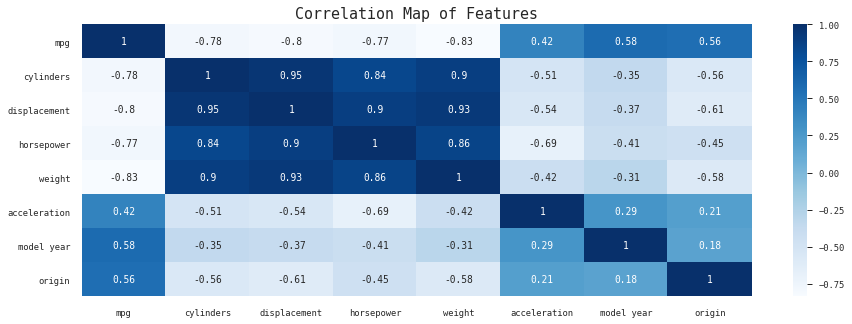

In [15]:
sns.heatmap(data.corr(), cmap='Blues', annot=True)
plt.title('Correlation Map of Features', size=15);

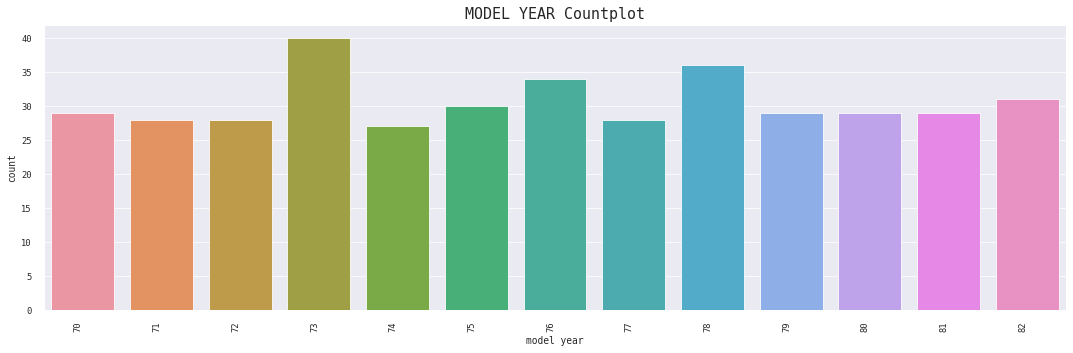

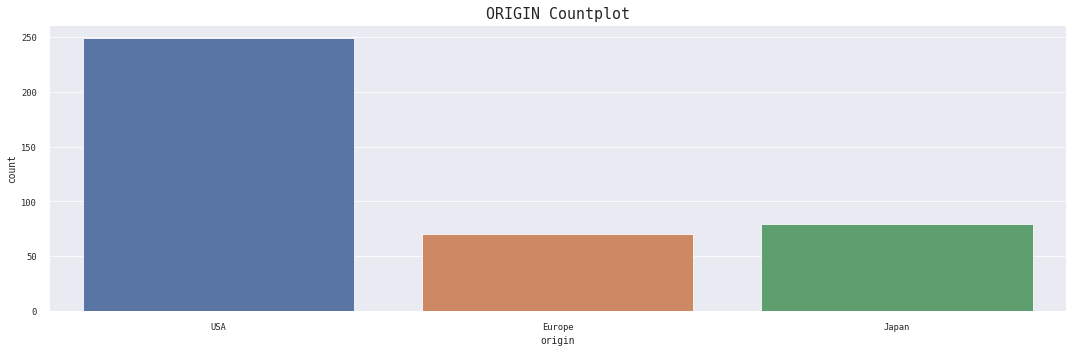

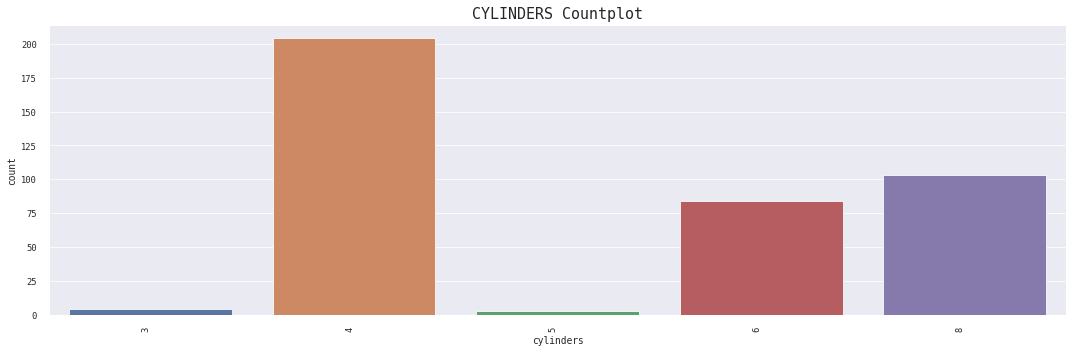

In [16]:
int_cols = ['model year', 'origin', 'cylinders']

for col in int_cols:
    g = sns.countplot(x=col, data=data)
    if col == 'origin':
      g.set_xticklabels(['USA', 'Europe', 'Japan'])
    else:
      g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
    plt.title(col.upper()+' Countplot', size=15)
    plt.tight_layout()
    plt.show()

### Build and Evaluate Model

one-hot encode cylinders and origin columns

In [17]:
data = pd.get_dummies(columns=['origin', 'cylinders'], data = data, dtype=np.float64)
data.head() 

,mpg,displacement,horsepower,weight,acceleration,model year,origin_1,origin_2,origin_3,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8
0,18.0,307.0,130.0,3504,12.0,70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,15.0,350.0,165.0,3693,11.5,70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,18.0,318.0,150.0,3436,11.0,70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,16.0,304.0,150.0,3433,12.0,70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,17.0,302.0,140.0,3449,10.5,70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
# norm_data = (data-data.mean())/data.std()
# norm_data.head()

### Xgboost

In [19]:
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error 

In [20]:
y = data['mpg']
X = data.drop('mpg', axis=1)
print(X.shape, y.shape) 

(398, 13) (398,)


In [21]:
kfold = KFold(n_splits=2, shuffle=True, random_state=1)

for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_avg = X_train.mean(); train_std = X_train.std()
    X_train = (X_train-train_avg) / train_std
    

In [22]:
def fit_predict(model, X, y, K, normalize=False):
    ''' Description: Train model specified on dataset using KFold 
        Arguements: model - regression machine learning model to be trained 
                  X - training dataset
                  y - target column
                  K - number of splits
        Returns average rmse model name
    ''' 
    scores = 0
    # initiate StratifiedKFold 
    kfold = KFold(n_splits=K, shuffle=True, random_state=1)

    for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if normalize:
            train_avg = X_train.mean(); train_std = X_train.std()
            # normalize train dataset
            X_train = (X_train-train_avg) / train_std
            # normalize test dataset with mean and std of train dataset
            X_test = (X_test-train_avg) / train_std
        # training  
        model.fit(X_train, y_train)    
        # predicting on test set
        pred = model.predict(X_test)
        # rmse
        rmse = mean_squared_error(y_test, pred, squared=False)
        # take mean of rmse scores
        scores += rmse/K

        if i % 4 == 0:
            print('Fold {} RMSE: {}'.format(i+1, rmse))
            print('='*45)

    print()
    print('Avg RMSE: {:.4f} '.format(scores))

    return scores, model 

In [23]:
xgb_ = xgb.XGBRegressor(random_state=42)
xgb_rmse, xgb_1 = fit_predict(xgb_, X, y, 25) 

Fold 1 RMSE: 2.1417929076304496
Fold 5 RMSE: 3.1045072714156636
Fold 9 RMSE: 2.0750055360575836
Fold 13 RMSE: 2.318307424592099
Fold 17 RMSE: 2.008895886707492
Fold 21 RMSE: 4.702969677909745
Fold 25 RMSE: 2.35803286149656

Avg RMSE: 2.7153 


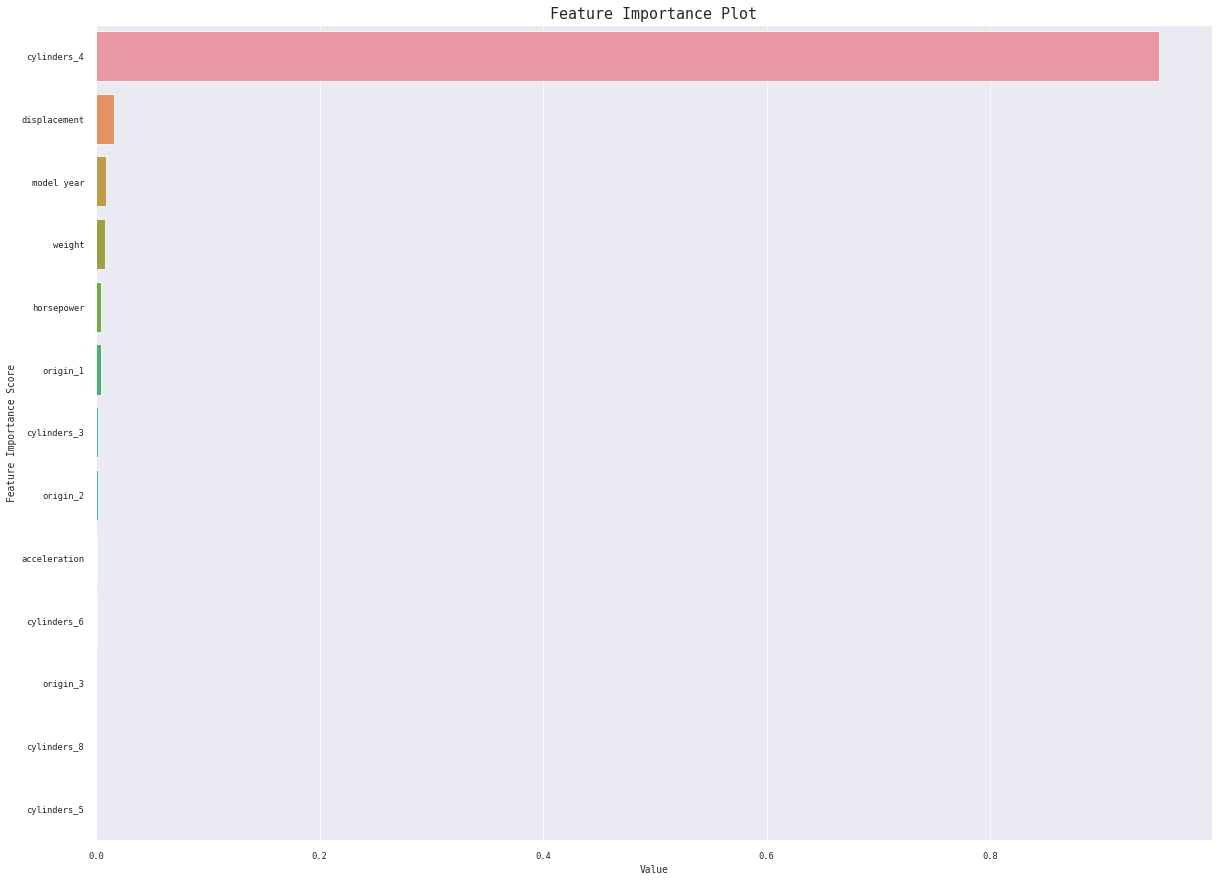

In [24]:
feat_imp = pd.DataFrame(sorted(zip(xgb_1.feature_importances_,X.columns)), 
                              columns=['Value','Feature']) 
plt.figure(figsize=(20,15))
imp_data = feat_imp.sort_values(by="Value", ascending=False)
sns.barplot(x="Value", y="Feature", data=imp_data.iloc[:50])
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance Plot', size=15)
plt.show() 

In [25]:
result = {}

In [26]:
result['Vanilla data RMSE'] = xgb_rmse
print(result)

{'Vanilla data RMSE': 2.7153209172874364}


In [27]:
xgb_rmse_norm, xgb_1 = fit_predict(xgb_, X, y, 25, normalize=True)

Fold 1 RMSE: 2.1417929076304496
Fold 5 RMSE: 3.10444346372019
Fold 9 RMSE: 2.0750055360575836
Fold 13 RMSE: 2.318307424592099
Fold 17 RMSE: 2.0086445486444937
Fold 21 RMSE: 4.702969677909745
Fold 25 RMSE: 1.9520161651909447

Avg RMSE: 2.6901 


In [28]:
result['Normalised data RMSE'] = xgb_rmse_norm
print(result) 

{'Vanilla data RMSE': 2.7153209172874364, 'Normalised data RMSE': 2.690149642239111}


### Neural Network

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'tensorflow'

In [30]:
y = norm_data['mpg']
X = norm_data.drop('mpg', axis=1)
print(X.shape, y.shape) 

NameError: name 'norm_data' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(318, 13) (80, 13) (318,) (80,)


In [ ]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(X_train.columns)]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model
model = build_model()
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 100

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=2,
  callbacks=[early_stop])


Epoch 1/100
8/8 - 0s - loss: 0.0524 - mean_absolute_error: 0.1612 - mean_squared_error: 0.0524 - val_loss: 0.1176 - val_mean_absolute_error: 0.2709 - val_mean_squared_error: 0.1176
Epoch 2/100
8/8 - 0s - loss: 0.0496 - mean_absolute_error: 0.1514 - mean_squared_error: 0.0496 - val_loss: 0.1251 - val_mean_absolute_error: 0.2729 - val_mean_squared_error: 0.1251
Epoch 3/100
8/8 - 0s - loss: 0.0522 - mean_absolute_error: 0.1662 - mean_squared_error: 0.0522 - val_loss: 0.1364 - val_mean_absolute_error: 0.2864 - val_mean_squared_error: 0.1364
Epoch 4/100
8/8 - 0s - loss: 0.0559 - mean_absolute_error: 0.1590 - mean_squared_error: 0.0559 - val_loss: 0.1311 - val_mean_absolute_error: 0.2945 - val_mean_squared_error: 0.1311
Epoch 5/100
8/8 - 0s - loss: 0.0495 - mean_absolute_error: 0.1537 - mean_squared_error: 0.0495 - val_loss: 0.1227 - val_mean_absolute_error: 0.2706 - val_mean_squared_error: 0.1227
Epoch 6/100
8/8 - 0s - loss: 0.0516 - mean_absolute_error: 0.1560 - mean_squared_error: 0.0516 

In [ ]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)
# rmse = np.sqrt(mse)
print("Test Set Mean Squared Error: {:5.5f}".format(mse))

Test Set Mean Squared Error: 0.09011


0.3001832773490222